### Imports

In [1]:
import urllib
import random
import datetime
import numpy as np
import pandas as pd 
import tensorflow as tf
from dateutil import tz
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt 

--------------------------------------------------------------------------------------------------------------

### Gather the data and do some preprocessing

In [2]:
url = 'https://raw.githubusercontent.com/Eligijus112/Vilnius-weather-LSTM/main/data/weather.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
date_time = pd.to_datetime(df.pop('dt_iso'), format='%Y-%m-%d %H:%M:%S %z UTC')

In [5]:
df = df[['temp', 'pressure', 'wind_speed', 'wind_deg', 'humidity']]

In [6]:
wv = df.pop('wind_speed')

# Convert to radians.
wd_rad = df.pop('wind_deg')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

In [7]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

# Add time-of-day and time-of-year signals.
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#### Preview of the data

In [8]:
df.head()

,temp,pressure,humidity,Wx,Wy,Day sin,Day cos,Year sin,Year cos
0,-7.52,1032,87,-2.000000,2.449294e-16,-2.208429e-12,1.000000,0.002580,0.999997
1,-7.56,1032,87,-2.000000,2.449294e-16,2.588190e-01,0.965926,0.003297,0.999995
2,-7.67,1028,96,-2.077149,-1.088588e-01,5.000000e-01,0.866025,0.004014,0.999992
3,-7.74,1028,96,-2.179668,-3.804625e-02,7.071068e-01,0.707107,0.004731,0.999989
4,-7.66,1028,95,-2.120000,2.596251e-16,8.660254e-01,0.500000,0.005448,0.999985


#### Split the data as it was done in the experiments

In [9]:
n_rows = df.shape[0]
train_split = 0.70
val_split = 0.20
test_split = 0.10

train = df[0:int(n_rows*train_split)]
val = df[int(n_rows*train_split):int(n_rows*(train_split+val_split))]
test = df[int(n_rows*(train_split+val_split)):]

#### Normalize all data based on the training set

In [10]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
val = (val - train_mean) / train_std
test = (test - train_mean) / train_std

scaled_data = pd.concat([train, val, test])

#### Generate Windows - 168 hours input, next 24 hours output

In [11]:
def generateWindows(data, input_length, label_length):
    inputs = []
    labels = []
    n_features = data.shape[1]
    total_length = input_length + label_length

    for x in range(len(data) - input_length - label_length):
        labels.append(data[(x + input_length):(x + total_length), 0]) # 0 here is for first column, Temperature (C)
        inputs.append(data[x:(x + input_length)])

    inputs, labels = np.array(inputs), np.array(labels)

    inputs = np.reshape(inputs, (inputs.shape[0], input_length, n_features))

    return inputs, labels

In [12]:
input_window = 168
prediction_window = 24
inputs, labels = generateWindows(scaled_data.values, input_window, prediction_window)

#### Models are pretrained, only need the testing data

In [13]:
Xtest, Ytest = inputs[int(inputs.shape[0] * (train_split + val_split)):], labels[int(inputs.shape[0] * (train_split + val_split)):]

In [14]:
print(f"Shape of test data: {Xtest.shape}")
print(f"Shape of the test target data: {Ytest.shape}")

Shape of test data: (29404, 168, 9)
Shape of the test target data: (29404, 24)


--------------------------------------------------------------------------------------------------------------------------

### Load the three models: LSTM, CNN, CNN-LSTM

In [15]:
lstm_model = keras.models.load_model('lstm32model')
cnn_model = keras.models.load_model('cnn_model.h5')
combined_model = keras.models.load_model('combined_model.h5')

2022-12-07 16:18:05.882815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 16:18:05.882848: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 16:18:05.882870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-bcd3q): /proc/driver/nvidia/version does not exist
2022-12-07 16:18:05.883334: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


-----------------------------------------------------------------------------------------------------------------------------

### Make Predictions on the Test Data

In [16]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    preds = [(x * train_std['temp']) + train_mean['temp'] for x in preds]
    stacked_preds = np.hstack(preds)
    days_preds = stacked_preds.reshape(stacked_preds.shape[0], -1, 24)
    hours_list = []
    for x in range (0,days_preds.shape[0]):
        hours_list.append(days_preds[x].T)
    hours_preds = np.array(hours_list)
    return hours_preds, hours_preds.mean(axis=2), hours_preds.std(axis=2)

#### Edit the number of predictions as you please. The more predictions, the longer this step will take.

In [17]:
num_predictions = 20
y_pred_dist_lstm, y_mu_lstm, y_sigma_lstm = predict_dist(Xtest, lstm_model, num_predictions)
y_pred_dist_cnn, y_mu_cnn, y_sigma_cnn = predict_dist(Xtest, cnn_model, num_predictions)
y_pred_dist_combo, y_mu_combo, y_sigma_combo = predict_dist(Xtest, combined_model, num_predictions)

----------------------------------------------------------------------------------------------------------------------------

### Compare the three models on a day between September 24th, 2017 and November 30th, 2020

#### Enter a date:

In [18]:
day = 4
month = 8
year = 2019

In [19]:
zone = tz.gettz('UTC')
date = datetime(year, month, day, 0, 0, 0, 0, zone)

In [20]:
idx = date_time.index[date_time == date][0]
start = 294226 - 29404
i = idx - start

In [21]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
YtestAct = [(x * train_std['temp']) + train_mean['temp'] for x in Ytest[i]]

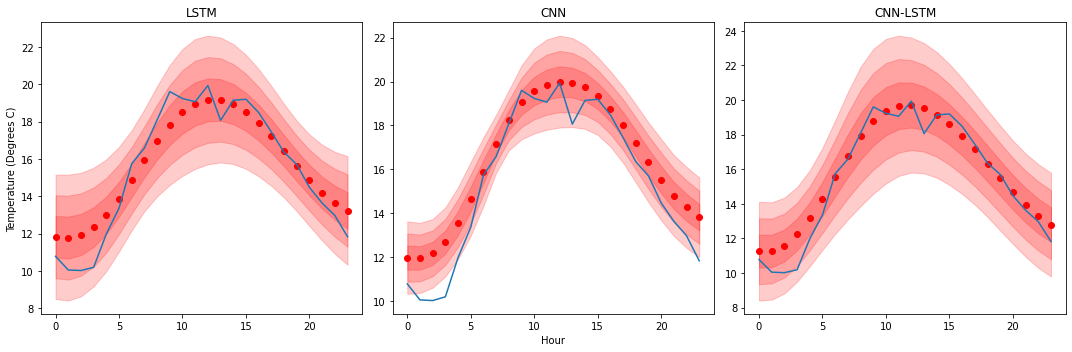

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(x,y_mu_lstm[i],'ro',label='Predictions')
axes[0].fill_between(x, y_mu_lstm[i]-y_sigma_lstm[i], y_mu_lstm[i]+y_sigma_lstm[i], alpha=0.2, color='red')
axes[0].fill_between(x, y_mu_lstm[i]-2.0*y_sigma_lstm[i], y_mu_lstm[i]+2.0*y_sigma_lstm[i], alpha=0.2, color='red')
axes[0].fill_between(x, y_mu_lstm[i]-3.0*y_sigma_lstm[i], y_mu_lstm[i]+3.0*y_sigma_lstm[i], alpha=0.2, color='red')
axes[0].plot(x,YtestAct)
axes[0].set_ylabel('Temperature (Degrees C)')
axes[0].set_title('LSTM')

axes[1].plot(x,y_mu_cnn[i],'ro',label='Predictions')
axes[1].fill_between(x, y_mu_cnn[i]-y_sigma_cnn[i], y_mu_cnn[i]+y_sigma_cnn[i], alpha=0.2, color='red')
axes[1].fill_between(x, y_mu_cnn[i]-2.0*y_sigma_cnn[i], y_mu_cnn[i]+2.0*y_sigma_cnn[i], alpha=0.2, color='red')
axes[1].fill_between(x, y_mu_cnn[i]-3.0*y_sigma_cnn[i], y_mu_cnn[i]+3.0*y_sigma_cnn[i], alpha=0.2, color='red')
axes[1].plot(x,YtestAct,label='Target')
axes[1].set_xlabel('Hour')
axes[1].set_title('CNN')

axes[2].plot(x,y_mu_combo[i],'ro',label='Predictions')
axes[2].fill_between(x, y_mu_combo[i]-y_sigma_combo[i], y_mu_combo[i]+y_sigma_combo[i], alpha=0.2, color='red')
axes[2].fill_between(x, y_mu_combo[i]-2.0*y_sigma_combo[i], y_mu_combo[i]+2.0*y_sigma_combo[i], alpha=0.2, color='red')
axes[2].fill_between(x, y_mu_combo[i]-3.0*y_sigma_combo[i], y_mu_combo[i]+3.0*y_sigma_combo[i], alpha=0.2, color='red')
axes[2].plot(x,YtestAct,label='Target')
axes[2].set_title('CNN-LSTM')

fig.tight_layout()